#### **IMPORT LIBRARIES**

In [8]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import xgboost as xgb
from sklearn.linear_model import LinearRegression

#### **TRAINING FUNCTION**

In [9]:
class func() :   
    def __init__(self, train, label, test, param, steps):
        self.train, self.label, self.test = train, label, test
        self.param, self.steps = param, steps
    
    def __call__(self, plot = True):
        return self.fit(plot)
    
    def fit(self, plot):
        X_train, X_test, y_train, y_test = train_test_split(self.train, self.label, test_size = 0.5, shuffle = True, random_state=1000)
        self.y_test = y_test
        X_train = xgb.DMatrix(X_train, label=y_train)
        X_test = xgb.DMatrix(X_test)
        model = xgb.train(self.param, X_train, self.steps)
        val_p = model.predict(X_test)
        print('\nValidation scores', np.sqrt(mean_squared_error(y_test, model.predict(X_test))))
        print('Training scores', np.sqrt(mean_squared_error(y_train, model.predict(X_train))))
        test_p = model.predict(xgb.DMatrix(self.test))
        if plot: self.plot_feat_imp(model)
        return val_p, test_p, model
    
    #To plot the feature importances of the model 
    def plot_feat_imp(self, model):
        feat_imp = pd.Series(model.get_fscore()).sort_values(ascending=False)
        plt.figure(figsize=(12,8))
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

#### **PREPROCESSING FUNCTIONS**

In [10]:
#Frequency encoding
def freq_encode(data, cols):
    for i in cols:
        encoding = data.groupby(i).size()
        encoding = encoding/len(data)
        data[i + '_enc'] = data[i].map(encoding)
    return data

#Target encoding with KFold
def mean_target(data, cols):
    kf = KFold(5)
    a = pd.DataFrame()
    for tr_ind, val_ind in kf.split(data):
        X_tr, X_val= data.iloc[tr_ind].copy(), data.iloc[val_ind].copy()
        for col in cols:
            means = X_val[col].map(X_tr.groupby(col).target.mean())
            X_val[col + '_mean_target'] = means + 0.0001
        a = pd.concat((a, X_val))
    prior = target.mean()
    a.fillna(prior, inplace=True)
    return a

#Function for automating feature interactions between important features to generate more information for the model.
def feature_interact(df, s_col):
    for i in s_col:
        for j in s_col: df[i + '/' + j] = df[i] / df[j]

    for i in s_col:
        for j in s_col: df[i + '+' + j] = df[i] + df[j]

    for i in s_col:
        for j in s_col: df[i + '-' + j] = df[i] - df[j]

    for i in s_col:
        for j in s_col: df[i + '*' + j] = df[i] * df[j]
    return df


#### **DATA PROCESSING**

In [11]:
train = pd.read_csv('train(1).csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('SampleSubmission(1).csv')

ntrain = train.shape[0]
ntest = test.shape[0]
target = train.target.copy()
df = pd.concat((train, test)).reset_index(drop=True)
df = df.drop('id', 1)

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df['CTR_CATEGO_X'] = encoder.fit_transform(df['CTR_CATEGO_X'])

df = freq_encode(df, ['ACT_CODACT', 'CTR_MATFIS'])
data = df.copy()

#### **MODEL 1**

In [12]:
df1 = df.copy()
train = df1[:ntrain].copy()
target = train.target.copy()
train.drop('target', axis=1, inplace=True)

test = df1[ntrain:].copy()
test.drop('target', axis=1, inplace=True)
test = test.reset_index(drop=True)

param = dict(eta =  0.1, 
             max_depth = 2,  
             objective =  'reg:squarederror',
             subsample = 0.8,
             colsample_bytree = 0.8,
            )
param['lambda'] = 100
func_= func(train, target, test, param, steps= 200)
val_p1, test_p1, model1 = func_(plot = False)


Validation scores 6.118051047388341
Training scores 5.964175407666334


#### **MODEL 2**


Validation scores 5.5347129991364925
Training scores 5.426061279874092


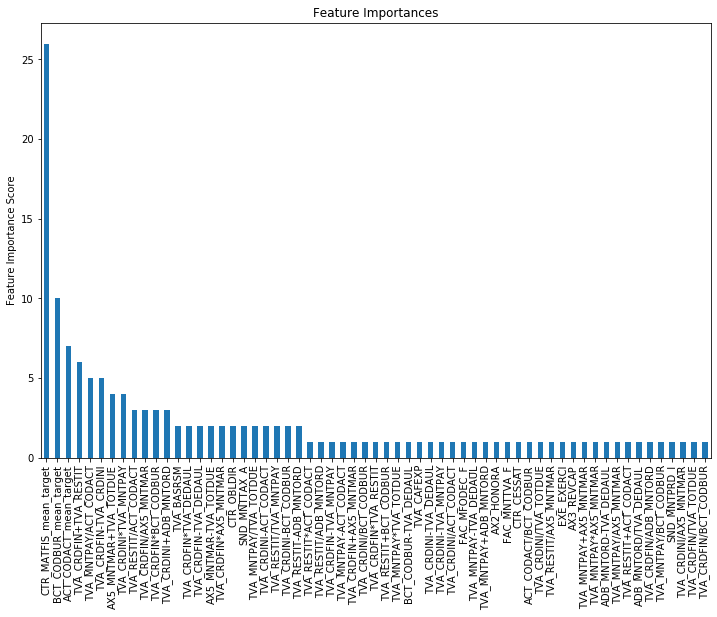

In [13]:
df2 = data.copy()

s_col = []
score = model1.get_score()
for i in score:
    if score[i] > 15:
        s_col.append(i)

df2 = mean_target(df2, ['ACT_CODACT', 'CTR_MATFIS', 'BCT_CODBUR'])

df2 = feature_interact(df2, s_col)

train = df2[:ntrain].copy()
target = train.target.copy()
train.drop('target', axis=1, inplace=True)

test = df2[ntrain:].copy()
test.drop('target', axis=1, inplace=True)
test = test.reset_index(drop=True)

param = dict(eta =  0.2, 
             max_depth = 3,  
             objective =  'reg:squarederror',
            )
param['lambda'] = 70
#param = dict(objective =  'reg:squarederror')
func_= func(train, target, test, param, steps= 20)
val_p2, test_p2, model2 = func_()

#### **MODEL 3**


Validation scores 5.520462652049092
Training scores 5.405277208882501


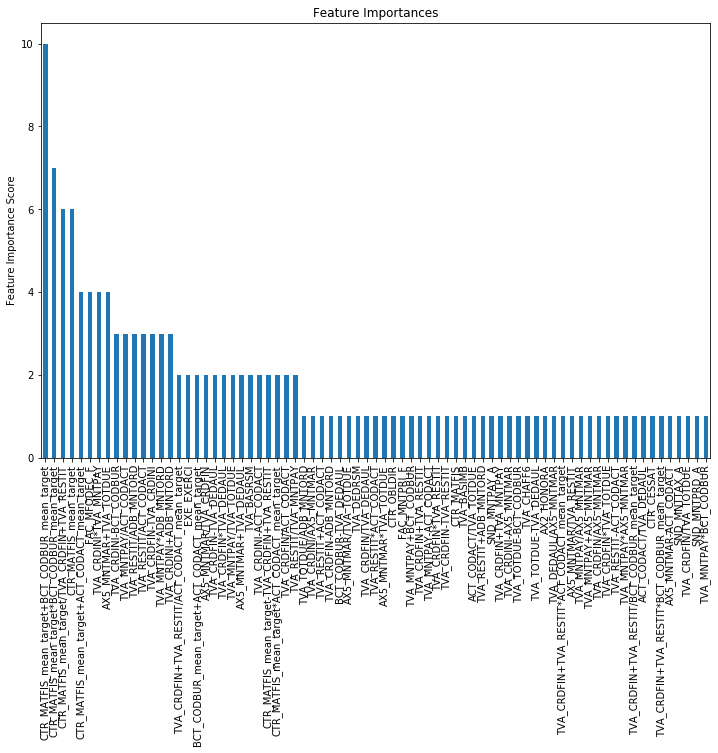

In [14]:
df3 = df2.copy()
s_col = []
score = model2.get_score()
for i in score:
    if score[i] > 5: s_col.append(i)
        
df3 = mean_target(df3, ['CTR_CATEGO_X'])

df3 = feature_interact(df3, s_col)
        
df3['MNTDAY/TOTDUE*CRDFIN'] = df3['TVA_MNTPAY/TVA_TOTDUE'] * df3['TVA_CRDFIN']

train = df3[:ntrain].copy()
target = train.target.copy()
train.drop('target', axis=1, inplace=True)

test = df3[ntrain:].copy()
test.drop('target', axis=1, inplace=True)
test = test.reset_index(drop=True)

param = dict(eta =  0.2, 
             max_depth = 3,  
             objective =  'reg:squarederror',
            )
param['lambda'] = 70
#param = dict(objective =  'reg:squarederror')
func_= func(train, target, test, param, steps= 20)
val_p3, test_p3, model3 = func_()

#### **MODEL 4**

In [15]:
df4 = df3.copy()
s_col = []
score = model3.get_score()
for i in score:
    if score[i] > 3: s_col.append(i)
        
df4 = mean_target(df4, ['CTR_OBLDIR'])

df4 = feature_interact(df4, s_col)

train = df4[:ntrain].copy()
target = train.target.copy()
train.drop('target', axis=1, inplace=True)

test = df4[ntrain:].copy()
test.drop('target', axis=1, inplace=True)
test = test.reset_index(drop=True)

param = dict(eta =  0.2, 
             max_depth = 4,  
             objective =  'reg:squarederror',
            )
param['lambda'] = 100
func_= func(train, target, test, param, steps= 20)
val_p4, test_p4, model4 = func_(plot=False)


Validation scores 5.495824570718901
Training scores 5.2731036040202826


#### **STACKING MODELS**

In [16]:
#Stacking models together will help improve score significantly.
#Using linear regression can help produce the best fit from predictions.

stack = np.column_stack((val_p1, val_p2, val_p3, val_p4))
stack_p = np.column_stack((test_p1, test_p2, test_p3, test_p4))
model_blend = LinearRegression()
model_blend.fit(stack, func_.y_test)
p = model_blend.predict(stack_p)

#### **SUBMISSION**

In [17]:
#Some of the results were negative which can never be possible in real cases based on train data.
#They had to be equated to zero which helped reduce final loss

In [18]:
for i,j in enumerate(p):
    if j < 0: p[i] = 0

In [20]:
submission['target'] = p

submission.to_csv('final_final.csv',index=False)

One of the most important generated features were the target encoded features for ['ACT_CODACT', 'CTR_MATFIS', 'BCT_CODBUR'].. This preprocessing helped introduced new information which was very useful for the model.

There are other things that can be done to improve accuracy..

1.     Dropping less important columns to reduce noise when moving to the next model
2.     Concatenating important categorical features to produce more features
3.     Target encoding on more categorical features and interacting results with other features
4.     Proper tuning of models, etc